## Packages

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import os

import collections
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import cleanlab
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import print_noise_matrix
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint

In [2]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(16, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    
def acc_loss_plot(network):
    accuracy = network.history['accuracy']
    val_accuracy = network.history['val_accuracy']
    loss = network.history['loss']
    val_loss = network.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'c', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

## Lectura de les dades

In [3]:
print(tf. __version__)

2.6.0


In [4]:
os.getcwd()

'C:\\Users\\aidaf\\TFG'

In [5]:
data_dir = os.path.join(os.getcwd() + "\\reduced")
data_dir

'C:\\Users\\aidaf\\TFG\\reduced'

In [6]:
classes = os. listdir(data_dir)
print(classes)

['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


In [7]:
dades_Y = np.load('labels_reduced.npy')
dades_X = np.load('images_reduced.npy')

dades_Y.shape, dades_X.shape

((4500,), (4500, 120, 120, 3))

In [8]:
clean_Y = np.load('labels_reduced_clean.npy')
clean_X = np.load('images_reduced_clean.npy')

clean_X.shape, clean_Y.shape

((500, 120, 120, 3), (500,))

## Descripció de les dades

In [9]:
dades_Y_clean, dades_Y_resta = dades_Y[0:1000], dades_Y[1000:4500]
dades_X_clean, dades_X_resta = dades_X[0:1000,], dades_X[1000:4500,]

Dimensió: 

In [10]:
print('Dimensions de les dades : ', dades_X_clean.shape, dades_Y_clean.shape)
print('Dimensions de les dades : ', dades_X_resta.shape, dades_Y_resta.shape)

Dimensions de les dades :  (1000, 120, 120, 3) (1000,)
Dimensions de les dades :  (3500, 120, 120, 3) (3500,)


Nombre de classes i etiquetes: 

In [11]:
n_classes = len(classes)
print('Nombre de classes : ', n_classes)
print('Etiquetes de les classes : ', classes)

Nombre de classes :  5
Etiquetes de les classes :  ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']


Distribució de les classes: 

In [12]:
print("Distribució de les classes : ",collections.Counter(dades_Y_clean))
print("Distribució de les classes : ",collections.Counter(dades_Y_resta))

Distribució de les classes :  Counter({0: 225, 2: 202, 3: 197, 1: 193, 4: 183})
Distribució de les classes :  Counter({4: 717, 1: 707, 3: 703, 2: 698, 0: 675})


# Augmentem encara més el soroll

In [13]:
noise_matrix = np.array([[.7,.2,.04,.03,.03],
                         [.2,.7,.04,.03,.03],
                         [.05,.01,.68,.13,.13],
                         [.01,.02,.12,.7,.15],
                         [.04,.04,.17,.05,.7]])

np.sum(noise_matrix,1) == 1

array([ True,  True,  True,  True,  True])

In [14]:
print_noise_matrix(noise_matrix)
np.random.seed(seed=1)
# Create the noisy labels. This method is exact w.r.t. the noise_matrix.
y_train_w_errors = generate_noisy_labels(dades_Y_resta, noise_matrix)


print("------------------------------------------------------")
print("% d'etiquetes netes: ",sum(y_train_w_errors == dades_Y_resta)/len(dades_Y_resta))

print("------------------------------------------------------")

dades_Y_one_hot = np.array(pd.get_dummies(dades_Y_clean))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')

train_X,valid_X,train_label,valid_label = train_test_split(dades_X_clean, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=dades_Y_one_hot)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(y_train_w_errors))


 Noise Matrix (aka Noisy Channel) P(s|y) of shape (5, 5)
 p(s|y)	y=0	y=1	y=2	y=3	y=4
	---	---	---	---	---
s=0 |	0.7	0.2	0.04	0.03	0.03
s=1 |	0.2	0.7	0.04	0.03	0.03
s=2 |	0.05	0.01	0.68	0.13	0.13
s=3 |	0.01	0.02	0.12	0.7	0.15
s=4 |	0.04	0.04	0.17	0.05	0.7
	Trace(matrix) = 3.48

------------------------------------------------------
% d'etiquetes netes:  0.6982857142857143
------------------------------------------------------
(900, 120, 120, 3) (100, 120, 120, 3) (900, 5) (100, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 745, 1: 721, 0: 684, 4: 683, 2: 667})


In [15]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X_clean.shape[1],dades_X_clean.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(n_classes, activation='softmax'))

# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 20
BS = 32

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [16]:
# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/20
29/29 [==============================] - 41s 1s/step - loss: 1.4236 - accuracy: 0.3889 - val_loss: 0.9133 - val_accuracy: 0.5700
Epoch 2/20
29/29 [==============================] - 32s 1s/step - loss: 0.8340 - accuracy: 0.6300 - val_loss: 0.8216 - val_accuracy: 0.6500
Epoch 3/20
29/29 [==============================] - 30s 1s/step - loss: 0.7011 - accuracy: 0.6833 - val_loss: 0.7256 - val_accuracy: 0.6600
Epoch 4/20
29/29 [==============================] - 29s 1s/step - loss: 0.5330 - accuracy: 0.7644 - val_loss: 0.6409 - val_accuracy: 0.7200
Epoch 5/20
29/29 [==============================] - 30s 1s/step - loss: 0.5031 - accuracy: 0.7811 - val_loss: 0.7676 - val_accuracy: 0.6300
Epoch 6/20
29/29 [==============================] - 30s 1s/step - loss: 0.5090 - accuracy: 0.7700 - val_loss: 0.6640 - val_accuracy: 0.7000
Epoch 7/20
29/29 [==============================] - 29s 1s/step - loss: 0.4807 - accuracy: 0.7889 - val_loss: 0.5331 - val_accuracy: 0.7100
Epoch 8/20
29/29 [==

In [17]:
model.save("model_70_1000.h5")

In [16]:
def_model = keras.models.load_model('model_70_1000.h5')
test_eval = def_model.evaluate(valid_X,valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.852557897567749
Test accuracy: 0.8100000023841858


In [17]:
predicted_classes = def_model.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

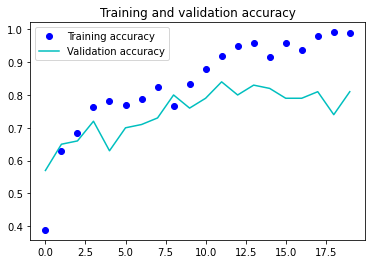

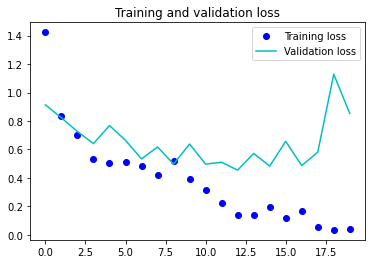

In [20]:
acc_loss_plot(H)

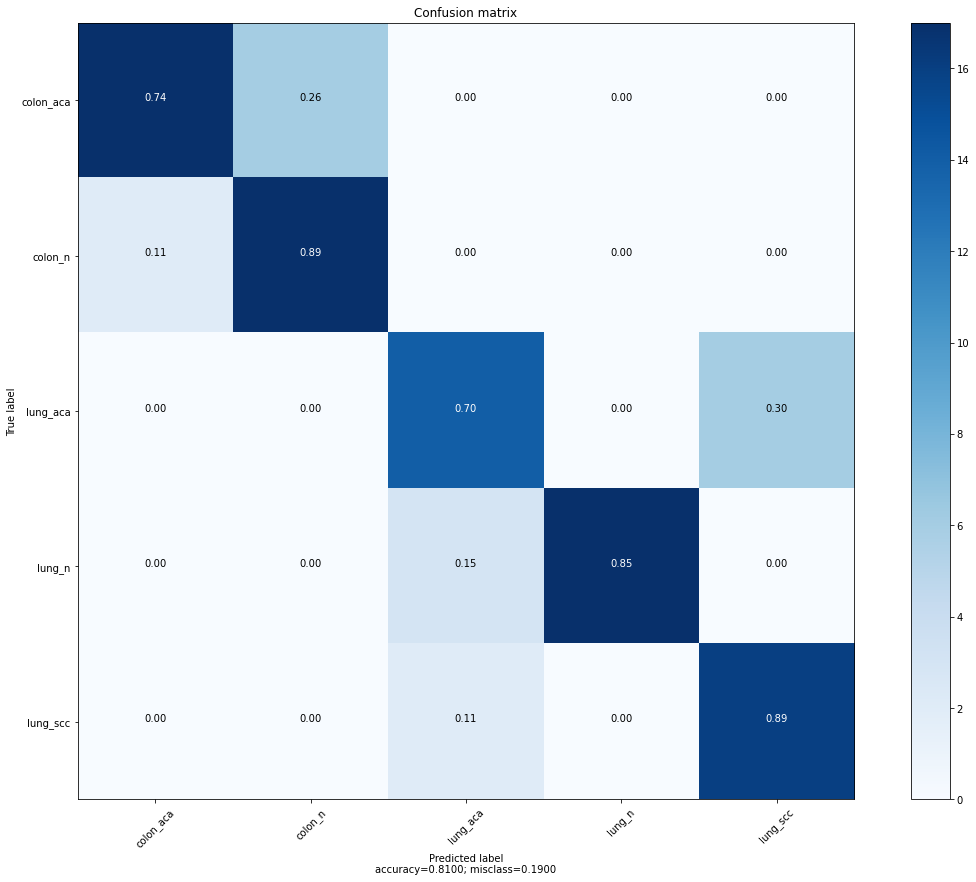

In [21]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

In [22]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.89      0.74      0.81        23
     colon_n       0.74      0.89      0.81        19
    lung_aca       0.74      0.70      0.72        20
      lung_n       1.00      0.85      0.92        20
    lung_scc       0.73      0.89      0.80        18

    accuracy                           0.81       100
   macro avg       0.82      0.81      0.81       100
weighted avg       0.82      0.81      0.81       100



In [23]:
## Comprovem com va classificar el model inicial entrenat amb les dades errònies¶
prediction = def_model.predict(clean_X)
pred_labs = []

for i in range(len(prediction)):
    pred_labs.append(np.argmax(prediction[i]))
    
sum(pred_labs == clean_Y)/len(clean_Y)

0.868

## Demanem al model que digui quines prediccions són errónies

In [38]:
prediccions = def_model.predict(dades_X_resta)

In [39]:
s = dades_Y_resta
psx = prediccions

In [40]:
label_error_mask = np.zeros(len(s), dtype=bool)
label_error_indices = compute_confident_joint(
    s, psx, return_indices_of_off_diagonals=True)[1]
baseline_conf_joint_only = label_error_mask    

# Method: C_confusion
baseline_argmax = baseline_methods.baseline_argmax(psx, s)

# Method: CL: PBC
baseline_cl_pbc = cleanlab.pruning.get_noise_indices(
    s, psx, prune_method='prune_by_class')

# ethod: CL: PBNR
baseline_cl_pbnr = cleanlab.pruning.get_noise_indices(
            s, psx, prune_method='prune_by_noise_rate')

# Method: CL: C+NR
baseline_cl_both = cleanlab.pruning.get_noise_indices(
    s, psx, prune_method='both')

clean_labels = {
        'conf_joint_only': ~baseline_conf_joint_only,
        'pruned_argmax': ~baseline_argmax,
        'cl_pbc': ~baseline_cl_pbc,
        'cl_pbnr': ~baseline_cl_pbnr,
        'cl_both': ~baseline_cl_both,
    }

In [41]:
aux = ((((baseline_conf_joint_only==baseline_argmax)
         ==(baseline_argmax==baseline_cl_pbc))
         ==((baseline_cl_pbc==baseline_cl_pbnr)
         ==(baseline_cl_pbnr==baseline_cl_both)))
         ==(baseline_cl_both==baseline_cl_pbnr))

In [42]:
sum(aux), sum(aux)/len(aux)

(3128, 0.8937142857142857)

In [43]:
X_defs = dades_X_resta[aux]
Y_defs = dades_Y_resta[aux]

print(X_defs.shape,Y_defs.shape)

(3128, 120, 120, 3) (3128,)


In [44]:
new_Y = np.concatenate((dades_Y_clean, Y_defs),axis = 0)
new_X = np.concatenate((dades_X_clean, X_defs),axis = 0)

print(new_X.shape,new_Y.shape)

(4128, 120, 120, 3) (4128,)


In [45]:
dades_Y_one_hot = np.array(pd.get_dummies(new_Y))
dades_Y_one_hot = dades_Y_one_hot.astype('float32')

train_X,valid_X,train_label,valid_label = train_test_split(new_X, dades_Y_one_hot, test_size=0.1, 
                                                           random_state=13,stratify=new_Y)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

print("------------------------------------------------------")

print("Distribució de les classes : ",collections.Counter(new_Y))

(3715, 120, 120, 3) (413, 120, 120, 3) (3715, 5) (413, 5)
------------------------------------------------------
Distribució de les classes :  Counter({3: 873, 1: 842, 4: 815, 0: 810, 2: 788})


In [57]:
model = Sequential()
model.add(Rescaling(1./255, input_shape=(dades_X_clean.shape[1],dades_X_clean.shape[2],3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear', padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

# fit model on the augmented dataset
# initialize the number of epochs and batch size
EPOCHS = 16
BS = 64

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [58]:
# train the network
H = model.fit(train_X, train_label, batch_size=BS, epochs=EPOCHS,
              verbose=1, validation_data=(valid_X, valid_label))

Epoch 1/16
59/59 [==============================] - 126s 2s/step - loss: 1.0196 - accuracy: 0.5602 - val_loss: 0.9823 - val_accuracy: 0.4915
Epoch 2/16
59/59 [==============================] - 124s 2s/step - loss: 0.4909 - accuracy: 0.7908 - val_loss: 0.3429 - val_accuracy: 0.8450
Epoch 3/16
59/59 [==============================] - 126s 2s/step - loss: 0.3880 - accuracy: 0.8382 - val_loss: 0.4032 - val_accuracy: 0.8620
Epoch 4/16
59/59 [==============================] - 124s 2s/step - loss: 0.3023 - accuracy: 0.8824 - val_loss: 0.2899 - val_accuracy: 0.8692
Epoch 5/16
59/59 [==============================] - 125s 2s/step - loss: 0.2082 - accuracy: 0.9141 - val_loss: 0.1713 - val_accuracy: 0.9419
Epoch 6/16
59/59 [==============================] - 126s 2s/step - loss: 0.1834 - accuracy: 0.9303 - val_loss: 1.5162 - val_accuracy: 0.6634
Epoch 7/16
59/59 [==============================] - 136s 2s/step - loss: 0.4908 - accuracy: 0.8013 - val_loss: 0.2831 - val_accuracy: 0.8983
Epoch 8/16
59

In [59]:
model.save("model_70_1000_defs.h5")

In [60]:
def_model_2 = keras.models.load_model('model_70_1000_defs.h5')
test_eval = def_model_2.evaluate(valid_X,valid_label, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.155084490776062
Test accuracy: 0.9588377475738525


In [61]:
predicted_classes = def_model_2.predict(valid_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
valid_labels = np.argmax(np.round(valid_label),axis=1)

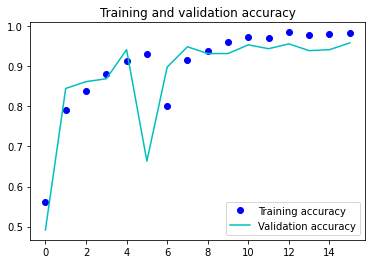

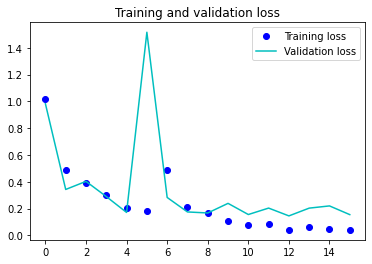

In [62]:
acc_loss_plot(H)

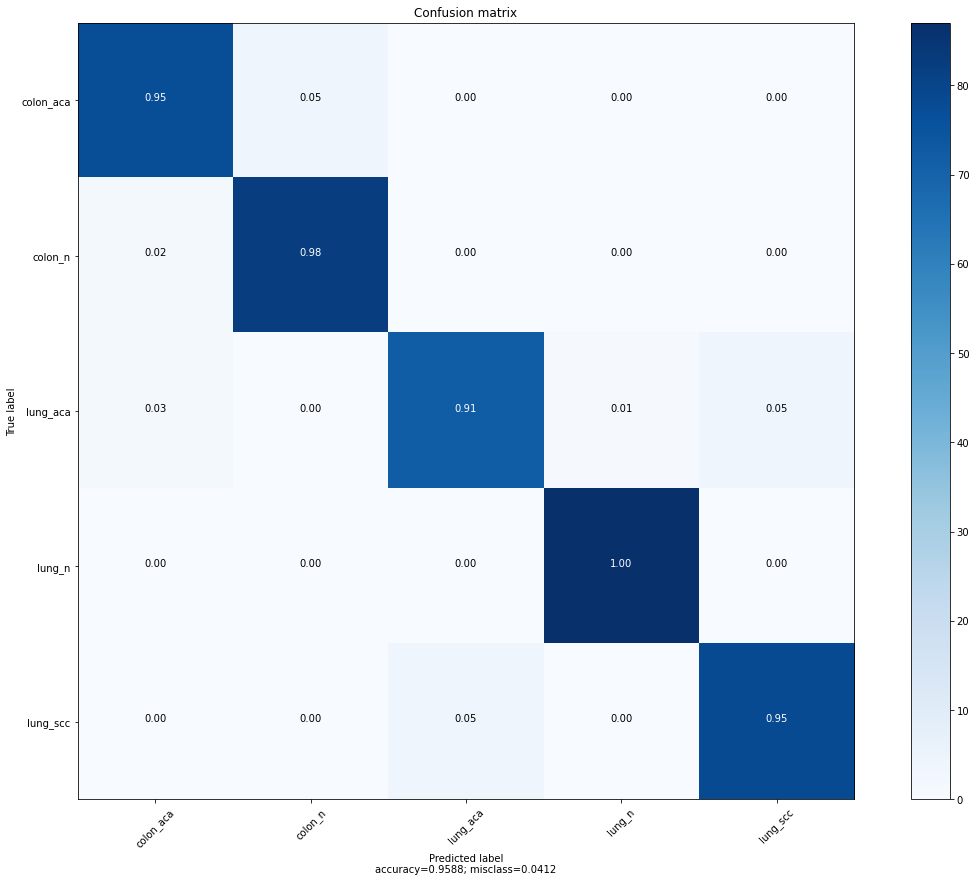

In [63]:
plot_confusion_matrix(confusion_matrix(valid_labels, predicted_classes), target_names = classes)

In [64]:
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(valid_labels, predicted_classes, target_names=classes))

              precision    recall  f1-score   support

   colon_aca       0.95      0.95      0.95        81
     colon_n       0.95      0.98      0.96        84
    lung_aca       0.95      0.91      0.93        79
      lung_n       0.99      1.00      0.99        87
    lung_scc       0.95      0.95      0.95        82

    accuracy                           0.96       413
   macro avg       0.96      0.96      0.96       413
weighted avg       0.96      0.96      0.96       413



### Comprovem com va classificar el model inicial entrenat amb les dades errònies

In [65]:
def_model_defs = keras.models.load_model('model_70_1000_defs.h5')

In [66]:
prediction = def_model_defs.predict(clean_X)
pred_labs_defs = []

for i in range(len(prediction)):
    pred_labs_defs.append(np.argmax(prediction[i]))

In [67]:
sum(pred_labs_defs == clean_Y)/len(clean_Y)

0.894